# Import libraries and data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python


In [8]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 4.8 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [9]:
#import libraries
import itertools
from prophet import Prophet
import pandas as pd
import numpy as np

In [10]:
#get the data
data = pd.read_csv("Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [11]:
#select variables
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)                       

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#Data Transformation

In [12]:
#Date variable
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [13]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


#holidays

In [14]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [15]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


#Training and Test Set

In [16]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846


#Facebook Prophet

In [17]:
#Facebook Prophet model
m = Prophet(growth = "linear",  # If ‘logistic’ specified float for ‘growth_cap’ must be provided.
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays, 
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/pv2k1oid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/uef_gspk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39223', 'data', 'file=/tmp/tmp9jzc_2_p/pv2k1oid.json', 'init=/tmp/tmp9jzc_2_p/uef_gspk.json', 'output', 'file=/tmp/tmp53uqbh6j/prophet_model-20220829121233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#forecasting 

In [18]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [19]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [20]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1706.767610,57.656556,1894.600062,1706.767610,1706.767610,-0.040222,-0.040222,-0.040222,-0.303611,...,0.000000,0.000000,0.000000,-0.273694,-0.273694,-0.273694,0.0,0.0,0.0,977.097369
1,2011-01-02,1716.317917,-101.267425,1699.576173,1716.317917,1716.317917,-0.043607,-0.043607,-0.043607,-0.309362,...,0.000000,0.000000,0.000000,-0.265928,-0.265928,-0.265928,0.0,0.0,0.0,801.031690
2,2011-01-03,1725.868224,252.825555,1968.102962,1725.868224,1725.868224,-0.099881,-0.099881,-0.099881,-0.074424,...,0.156888,0.156888,0.156888,-0.256858,-0.256858,-0.256858,0.0,0.0,0.0,1044.716645
3,2011-01-04,1735.418531,234.251613,1986.733385,1735.418531,1735.418531,-0.092102,-0.092102,-0.092102,-0.066087,...,0.156888,0.156888,0.156888,-0.246605,-0.246605,-0.246605,0.0,0.0,0.0,1132.726106
4,2011-01-05,1744.968839,358.925675,2208.902296,1744.968839,1744.968839,-0.086230,-0.086230,-0.086230,0.006625,...,0.156888,0.156888,0.156888,-0.235309,-0.235309,-0.235309,0.0,0.0,0.0,1273.134874


In [21]:
#predictions
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

700    4181.811575
701    3521.452996
702    5710.504562
703    5708.060461
704    5405.146264
Name: prophet, dtype: float64

#Visualization

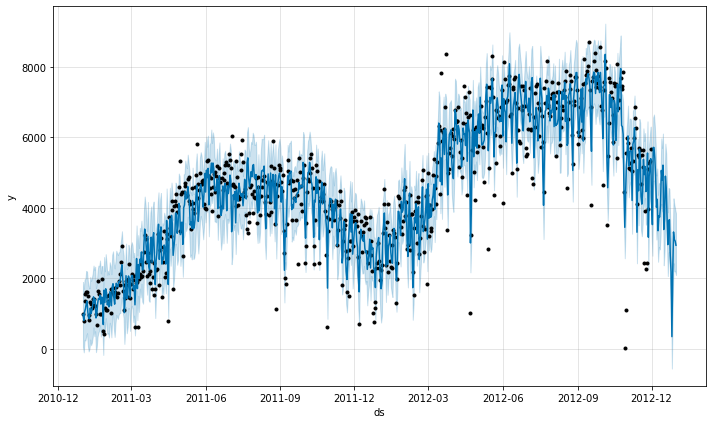

In [22]:
#visualization forecast
m.plot(forecast);

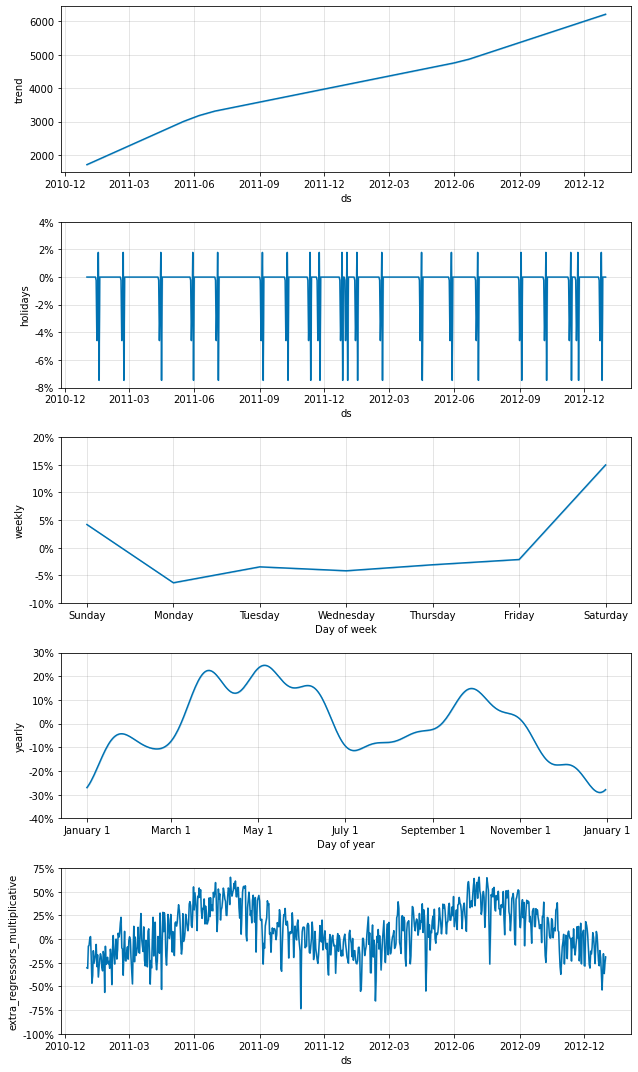

In [23]:
#plot components
m.plot_components(forecast);

#Model assessment

In [26]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))
print(mean_absolute_percentage_error(test_set['y'], predictions_prophet))

857.0
1027.0
0.34626354007376914


In [27]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

34.62635400737691

# Cross-Validation

In [28]:
#CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
df_cv.head()

INFO:prophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd1c92c1fd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/d1y9ke63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/mjfhbj02.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/oahqhhav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62515', 'data', 'file=/tmp/tmp9jzc_2_p/d1y9ke63.json', 'init=/tmp/tmp9jzc_2_p/oahqhhav.json', 'output', 'file=/tmp/tmp13wondyg/prophet_model-20220829121557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/t9g_1ive.json
12:15:57 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8177.812275,7457.138488,8902.232216,5463,2012-06-28
1,2012-06-30,7242.956193,6467.374325,7982.321128,5687,2012-06-28
2,2012-07-01,7446.357803,6653.349958,8219.237835,5531,2012-06-28
3,2012-07-02,6783.992349,6002.288658,7524.192817,6227,2012-06-28
4,2012-07-03,7453.942608,6736.698000,8227.290441,6660,2012-06-28


In [29]:
#MAE and RMSE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(mean_absolute_percentage_error(df_cv['y'], df_cv['yhat']))

1005.0
1270.0
1.2802712646005476


#Hyperparameter tuning

In [30]:
#Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'holidays_prior_scale': [5, 10, 20]}
grid = ParameterGrid(param_grid)
list(grid)[:3]            

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [31]:
#Hyper parameter tuning
rmse = []
for params in grid:
  #build model
  m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('workingday')
  m.add_regressor('weathersit')
  m.add_regressor('temp')
  m.add_regressor('atemp')
  m.add_regressor('hum')
  m.add_regressor('windspeed')
  m.fit(training_set)

  #cross-validation
  df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
  
  #gather the results
  error = np.sqrt(mean_squared_error(df_cv['y'], 
                                     df_cv['yhat']))
  rmse.append(error)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/bl97km67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/uucdakyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70114', 'data', 'file=/tmp/tmp9jzc_2_p/bl97km67.json', 'init=/tmp/tmp9jzc_2_p/uucdakyh.json', 'output', 'file=/tmp/tmpsyz64kun/prophet_model-20220829131116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:11:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:11:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd1b520ffd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/_o7206

In [32]:
#best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 10, 'holidays_prior_scale': 10, 'changepoint_prior_scale': 0.01}


#Final Prophet Model

In [33]:
#build model
m = Prophet(growth = "linear",
          yearly_seasonality = True,
          weekly_seasonality = True,
          daily_seasonality = False,
          holidays = holidays,
          seasonality_mode = "multiplicative",
          seasonality_prior_scale = best_params['seasonality_prior_scale'],
          holidays_prior_scale = best_params['holidays_prior_scale'],
          changepoint_prior_scale = best_params['changepoint_prior_scale'])
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/p261jigd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jzc_2_p/6k4lgw1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57431', 'data', 'file=/tmp/tmp9jzc_2_p/p261jigd.json', 'init=/tmp/tmp9jzc_2_p/6k4lgw1f.json', 'output', 'file=/tmp/tmp5j74htgm/prophet_model-20220829131817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,1,2,0.215833,0.223487,0.5775,0.154846


In [35]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2464.781042,336.285678,2160.432731,2464.781042,2464.781042,-0.055153,-0.055153,-0.055153,-0.283583,...,0.000000,0.000000,0.000000,-0.266583,-0.266583,-0.266583,0.0,0.0,0.0,1244.764078
1,2011-01-02,2470.205925,58.665686,1909.984583,2470.205925,2470.205925,-0.059795,-0.059795,-0.059795,-0.291137,...,0.000000,0.000000,0.000000,-0.259540,-0.259540,-0.259540,0.0,0.0,0.0,1002.840665
2,2011-01-03,2475.630807,379.578922,2259.654234,2475.630807,2475.630807,-0.136960,-0.136960,-0.136960,-0.196844,...,0.029157,0.029157,0.029157,-0.251190,-0.251190,-0.251190,0.0,0.0,0.0,1304.434943
3,2011-01-04,2481.055690,516.839599,2278.623571,2481.055690,2481.055690,-0.126293,-0.126293,-0.126293,-0.187623,...,0.029157,0.029157,0.029157,-0.241658,-0.241658,-0.241658,0.0,0.0,0.0,1416.799861
4,2011-01-05,2486.480572,667.090506,2537.291931,2486.480572,2486.480572,-0.118241,-0.118241,-0.118241,-0.119130,...,0.029157,0.029157,0.029157,-0.231092,-0.231092,-0.231092,0.0,0.0,0.0,1604.593894


In [36]:
#extract predictions
predictions_prophet_tuned = forecast.yhat[-test_days:].rename("prophet_tuned")
predictions_prophet_tuned.index = test_set["ds"]
predictions_prophet_tuned.head()

ds
2012-12-01    4113.640588
2012-12-02    3488.968320
2012-12-03    5613.070180
2012-12-04    5597.516900
2012-12-05    5310.016966
Name: prophet_tuned, dtype: float64

#export forecasts

In [37]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble


In [38]:
predictions_prophet_tuned.to_csv('predictions_prophet_tuned.csv', index = True)

In [39]:
print(round(mean_absolute_error(test_set['y'], predictions_prophet_tuned),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet_tuned)), 0))
print(mean_absolute_percentage_error(test_set['y'], predictions_prophet_tuned))

900.0
1031.0
0.3396627245641183
